# 9장 비지도학습

## 주요 내용

* 군집화
* k-평균
* DBSCAN
* 가우시안 혼합

__참고:__ 
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 9.1 군집화

### 분류 대 군집화

In [2]:
from sklearn.datasets import load_iris

In [3]:
data = load_iris()

X = data.data
y = data.target

In [4]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

아래 코드는 분류와 군집화의 차이를 보여주는 그림을 그린다. 

* 왼편: 각 샘플이 속하는 품종에 따른 분류
* 오른편: 지정된 기준에 따라 비슷한 샘플들끼리 그룹짓기

Saving figure classification_vs_clustering_plot


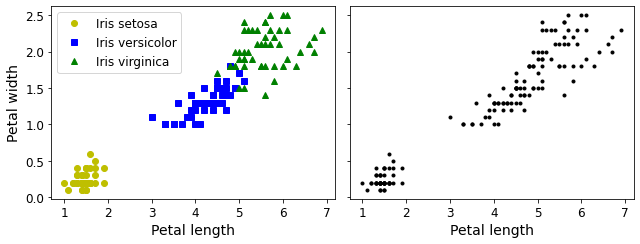

In [5]:
plt.figure(figsize=(9, 3.5))

# 왼편 그림: 분류
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

# 오른편 그림: 군집화
plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

꽃잎 길이와 너비만으로는 두 개의 군집으로만 구분이 가능해 보인다. 
하지만 꽃잎의 길이와 너비와 더불어 꽃받침의 길이와 너비까지 포함한
네 개의 특성을 모두 사용하여 후반부에서 가우시안 혼합 모델을 이용하여
세 개의 군집으로 나눌 수 있다.

In [6]:
from sklearn.mixture import GaussianMixture

y_pred = GaussianMixture(n_components=3, random_state=42).fit(X).predict(X)

실제 타깃을 이용한 분류와 직접 비교하면 다음과 같으며,
버시컬러와 버지니카 품종의 군집이 거의 정확하게 구분된 것을 확인할 수 있다.

Saving figure classification_vs_clustering_plot


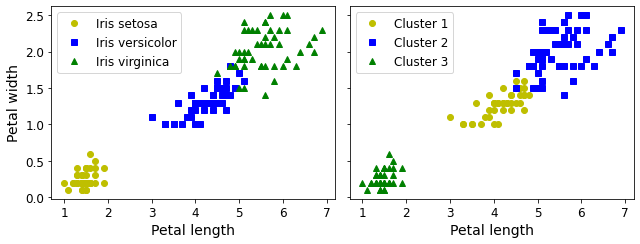

In [7]:
plt.figure(figsize=(9, 3.5))

# 왼편 그림: 실제 품종별 분류
plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

# 오른편 그림: 3개의 군집
plt.subplot(122)
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "yo", label="Cluster 1")   # 2번 군집: 세토사
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "bs", label="Cluster 2")   # 0번 군집: 버시컬러
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "g^", label="Cluster 3")   # 1번 군집: 버지니카
plt.xlabel("Petal length", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.tick_params(labelleft=False)

save_fig("classification_vs_clustering_plot")
plt.show()

군집화의 정확도를 확인하기 위해 군집별로 가장 많이 포함된 품종,
즉, 품종의 최빈값(mode)을 확인한다. 

아래 코드는 사이파이(scipy)의 통계 모듈에 포함되어 있는 `mode()` 함수를 이용하여 
각 군집별 최빈값을 확인한 후에 해당 최빈값과 군집 인덱스를 연결(mapping)한다.

In [8]:
from scipy import stats

mapping = {}

for class_id in np.unique(y):                   # 품종 아이디: 0, 1, 2
    mode, _ = stats.mode(y_pred[y==class_id])   # mode: 지정된 품종이 가장 많이 포함된 군집 인덱스
    mapping[mode[0]] = class_id                 # 군집 인덱스와 품종 연결

최종 결과는 다음과 같다.

- 2번 인덱스 군집: 세토사(0)가 제일 많음.
- 0번 인덱스 군집: 버시컬러(1)가 제일 많음.
- 1번 인덱스 군집: 버지니카(2)가 제일 많음.

In [9]:
mapping

{1: 0, 2: 1, 0: 2}

`mapping`을 이용하여 군집 인덱스를 품종 인덱스로 변경한 후에 군집화의 정확도를 
측정하면 96.7% 가 나온다.

**참고:** 사용하는 사이킷런 버전에 따라 조금씩 다른 결과가 나올 수 있다.

In [10]:
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

np.sum(y_pred==y) / len(y_pred)

0.9666666666666667

### 9.1.1 k-평균

먼저 2,000개의 데이터 샘플을 생성한다. 
생성되는 데이터는 지정된 5개의 센터를 중심으로 지정된 표준편차를 따르는 
원 모양의 데이터 군집을 이룬다.
또한 각각의 군집은 거의 동일한 크기를 갖는다.

* 5개의 센터와 표준편차

In [11]:
blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])

blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

`make_blobs()` 함수가 앞서 설명한 방식으로 데이터를 생성한다.

__참고:__ 각 샘플에 대한 실제 군집 인덱스가 타깃으로 함께 제공되지만
여기서는 사용하지 않는다.

In [12]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

산점도를 그리면 다음과 같다. 

In [13]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

Saving figure blobs_plot


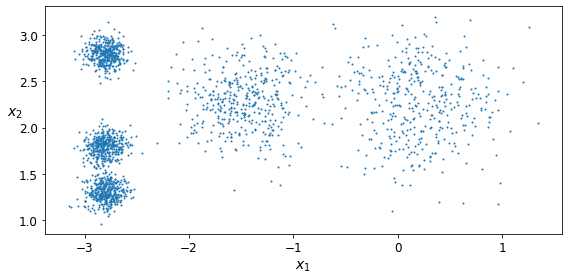

In [14]:
plt.figure(figsize=(8, 4))
plot_clusters(X)
save_fig("blobs_plot")
plt.show()

#### 군집화 훈련과 예측

사이킷런 `KMeans` 모델의 
`fit()` 메서드는 각 군집의 중심(센트로이드)을 잡은 다음에 모든 샘플에 대해 가장 가까운 
센트로이드를 중심으로 하는 군집을 이루도록 한다. 
다만, 센트로이드를 몇 개로 할 것인지 먼저 지정해야 하며,
여기서는 5개를 사용하여 훈련시킨다.

In [15]:
from sklearn.cluster import KMeans

In [16]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

훈련 결과 `kmeans.labels_` 속성에 각 훈련 샘플에 대한 군집 인덱스가 저장된다.

__참고:__ 앞서 붓꽃 데이터 군집화에서 살펴본 것처럼 
데이터가 생성될 때 지정된 실제 군집 인덱스가 아닌 
훈련 과정에서 무작위로 지정된 인덱스임에 주의해야 한다.

In [17]:
kmeans.labels_

array([4, 0, 1, ..., 2, 1, 0], dtype=int32)

각 군집의 중심, 즉 5개의 센트로이드의 좌표는 다음과 같다.

In [18]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

`predict()` 메서드를 이용하여 새로운 데이터에 대한 군집 예측도 가능하다.

In [19]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])

kmeans.predict(X_new)

array([1, 1, 2, 2], dtype=int32)

#### 결정경계

군집을 나누는 결정경계를 그리면 
[보로노이 다이어그램](https://en.wikipedia.org/wiki/Voronoi_diagram)이 
생성된다.

`plot_data()` 함수는 여기서만 사용되는 기본값이 지정된 산점도를 그린다.

In [20]:
# 산점도 그리기

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

`plot_centroids()` 함수는 센트로이드를 시각화한다. 

* `weights=None` 옵션: 특정 가중치 이상의 센트로이드만 그리도록 하는 설정.
    나중에 가우시안 혼합 모델을 시각화할 때 사용됨.

In [21]:
# 센트로이드 그리기
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]

    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

`plot_decision_boundaries()` 함수는 결정경계를 시각화한다. 

- `clusterer`: 훈련된 군집화 모델 객체
- `X`: 훈련 세트

In [22]:
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    
    # 바탕화면 그리기
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    
    # 훈련 샘플 산점도 그리기
    plot_data(X)
    
    # 센트로이드 그리기
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    # 기타: x, y 축 레이블
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_plot


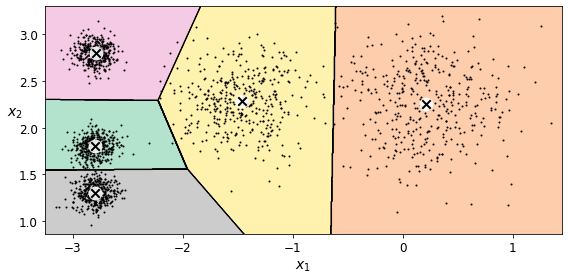

In [23]:
plt.figure(figsize=(8, 4))

plot_decision_boundaries(kmeans, X)

save_fig("voronoi_plot")
plt.show()

경계 근처의 일부 데이터가 잘못된 군집에 포함되긴 하였지만 전반적으로 군집이 잘 형성되었다.

#### 군집화와 차원축소

지금까지 살펴 보았듯이 k-평균 모델 객체의 `labels_` 속성은 각 샘플에 대해 가장 가까운
센트로이드를 중심으로 하는 군집의 (작위적으로 지정된) 인덱스를 저장하며,
이를 이용하여 `predict()` 메서드는 샘플이 속하는 군집의 인덱스를 반환한다.
이런 방식의 군집화가 __하드 군집화__(hard clustering)이다.

반면에 __소프트 군집화__(soft clustering)는 샘플과 각 군집 사이의 관계를 __점수__로 부여한다.
점수는 예를 들어 각 군집과 샘플사이의 거리 또는 5장에서 소개한 가우시안 방사기저 함수를 이용한 
유사도 점수 등이 사용될 수 있다. 
k-평균 모델 객체의 `transform()` 메서드는 샘플과 각 센트로이드 사이의 (유클리드) 거리를 점수로 
사용한다. 

아래 코드는 네 개의 새 데이터를 변환하는 것을 보여준다. 

In [24]:
kmeans.transform(X_new)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

&#x270b; 앞서 설명한 대로 각 샘플에 대한 반환값은 각 센트로이드로부터의 (유클리드) 거리임을
아래와 같이 확인할 수 있다.

* `np.tile()`: 주어진 어레이를 타일 모양의 지정된 형식으로 복제해서 이어붙이는 함수

In [25]:
np.linalg.norm(np.tile(X_new, (1, k)).reshape(-1, k, 2) - kmeans.cluster_centers_, axis=2)

array([[2.81093633, 0.32995317, 2.9042344 , 1.49439034, 2.88633901],
       [5.80730058, 2.80290755, 5.84739223, 4.4759332 , 5.84236351],
       [1.21475352, 3.29399768, 0.29040966, 1.69136631, 1.71086031],
       [0.72581411, 3.21806371, 0.36159148, 1.54808703, 1.21567622]])

k-평균 모델의 `transform()` 메서드는 결론적으로 기존 $n$-차원의 데이터셋을 
__비선형__적으로 $k$-차원의 데이터셋으로 변환하는
비선형 __차원축소__ 기법으로 사용될 수 있다.

__참고:__ 
[국소적 선형 임베딩](https://scikit-learn.org/stable/modules/manifold.html#locally-linear-embedding) 처럼
차원축소 기법을 군집화에 활용할 수도 있다. 

#### k-평균 알고리즘

k-평균 알고리즘은 가장 빠르며 가장 간단한 군집화 알고리즘 중 하나이다. 

* $k$ 개의 센트로이드 무작위 지정.
* 센트로이드의 위치가 특정 위치에 수렴할 때까지 아래 과정 반복
    - 모든 샘플에 대해 가장 가까운 센트로이드 지정
    - 각각의 센트로이드와 연결된 샘플들의 평균으로 해당 센트로이도 위치 수정

#### 사이킷런의 `KMeans` 클래스

`KMeans` 클래스의 기본 옵션 중 몇 가지는 다음과 같다.

* `init='k-means++'`: 초기화 알고리즘. 
    - `'random'`을 사용할 경우 무작위 지정.
    - `'k-means++'`: 센트로이드 간의 거리를 최대한 크게하는 알고리즘. 기본값으로 사용됨.
* `n_init=10`: 센트로이드 반복 지정 횟수. 기본값은 10.
* `algorithm='elkan'`: k-평균 알고리즘. 
    - `'full'`: 앞서 설명한 알고리즘
    - `'elkan'`: 개선된 알고리즘
    - `'auto'`: 기본적으로 `'elkan'` 선택.
* `max_iter=300`: 초기화된 센트로이드 위치 반복 업데이트 횟수.

여기서는 예시를 위해 아래 옵션을 대신 사용한다. 

* `init="random"`
* `n_init=1`
* `algorithm="full"`
* `max_iter`: 1, 2, 3

In [26]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)

kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=0)

kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=0)

각 단계별 결정경계와 센트로이드의 변화는 다음과 같다.

Saving figure kmeans_algorithm_plot


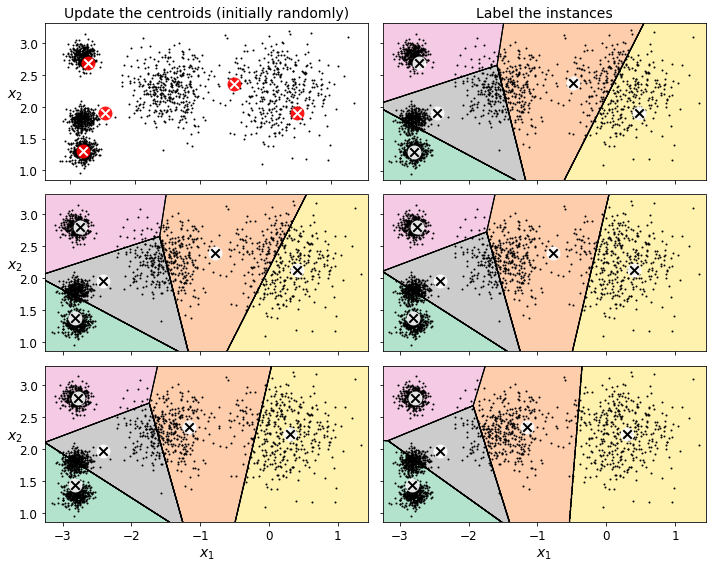

In [27]:
plt.figure(figsize=(10, 8))

# 맨 위 왼편
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

# 맨 위 오른편
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

# 가운데 왼편
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

# 가운데 오른편
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# 맨 아래 왼편
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

# 맨 아래 오른편
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_plot")
plt.show()

### 센트로이드 초기화 문제와 해결법

#### 초기화 문제

초기화가 무작위로 이루어질 경우 적절하지 않은 군집화를 얻을 수 있다. 
아래 코드는 두 개의 나쁜 경우를 잘 보여준다. 

`plot_clusterer_comparison()` 함수는 두 개의 결정경계 그래프를 동시에 그려준다. 

In [28]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

아래 두 개의 그래프는 바로 이전의 경우처럼 센트로이드 초기화를 무작위로 딱 한 번 사용한 결과를 보여준다.
두 경우 모두 적절치 않는 모델을 생성한다.

Saving figure kmeans_variability_plot


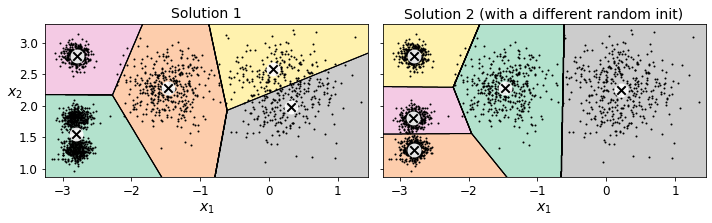

In [29]:
kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=2)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=5)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")

save_fig("kmeans_variability_plot")
plt.show()

#### 관성(inertia, 이너셔)

비지도 학습인 k-평균 모델의 성능을 __관성__(inertia)을 이용하여 측정한다. 

* 관성: 각 훈련 샘플과 가장 가까운 센트로이드 사이의 거리를 모두 합한 값
* `inertia_` 속성에 저장됨.

In [30]:
kmeans.inertia_

211.5985372581683

&#x270b; 아래 코드는 관성이 각 훈련 샘플과 가장 가까운 센트로이드 사이의 거리를 모두 합한 값임을 확인해준다.

In [31]:
X_dist = kmeans.transform(X)  # 각 샘플과 센트로이드들 사이의 거리

np.sum(X_dist[np.arange(len(X_dist)), kmeans.labels_]**2)   # 팬시 인덱싱 활용

211.59853725816834

`score()` 메서드는 관성의 음숫값을 반환한다. 
이유는 "더 높은 점수가 더 좋다"의 원칙을 따라야 하기 때문이다. 

In [32]:
kmeans.score(X)

-211.59853725816825

#### 초기화 반복

무작위 초기와 문제를 해결하기 위해 k-평균 알고리즘의 초기화를 여러 번 실행한 다음에 가장 낮은 
관성을 보이는 모델을 최종 모델로 선택하면 되며, 실제로 이 옵션(`n_init=10`)이 
앞서 설명한 대로 KMeans 모델의 기본 하이퍼파라미터 값으로 설정되어 있다. 

아래에서 확인할 수 있듯이 기본 하이퍼파라미터를 사용한 `kmeans`의 관성이
한 번의 센트로이드 초기화를 사용하는 모델들의 관성보다 낮다.

In [33]:
kmeans_rnd_init1.inertia_

219.43539442771402

In [34]:
kmeans_rnd_init2.inertia_

211.5985372581683

실제로 `n_init=10`로 설정할 경우 앞서 살펴본 좋은 모델과 비슷한 결과를 얻는다.

In [35]:
kmeans_rnd_10_inits = KMeans(n_clusters=5, init="random", n_init=10,
                              algorithm="full", random_state=2)
kmeans_rnd_10_inits.fit(X)

KMeans(algorithm='full', init='random', n_clusters=5, random_state=2)

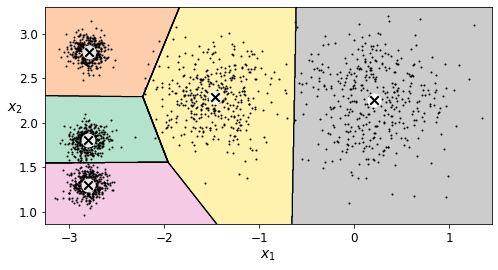

In [36]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans_rnd_10_inits, X)
plt.show()

관성 점수도 거의 최저다.

In [37]:
kmeans_rnd_10_inits.inertia_

211.59853725816828

#### K-Means++ 알고리즘

센트로이드 무작위 초기화 문제의 보다 근본적인 해결책이 
아서(David Arthur)와 바실비츠기(Sergei Vassilvitskii)의 
[2006년 논문](https://goo.gl/eNUPw6)에서 제시되었다. 
기본 아이디어는 기존 센트로이드들과의 거리가 멀 수록 다음 센트로이드로 선택될 확률이 높아지도록 하는 것이다. 

1. 균등분포를 따르면서 임의로 하나의 센트로이드 $c_1$ 선택 후 $k$ 개의
    센트로이드를 지정할 때까지 아래 과정 반복
1. $c_1, \dots, c_{i-1}$이 이미 선택되었가고 가정.
    1. 아래의 확률로 새로운 센트로이드 $c_i$로 $\mathbf{x}_i$ 선택:
    
        $$\frac{D(\mathbf{x}_i)^2}{\sum\limits_{j=1}^{m}{D(\mathbf{x}_j)}^2}$$
    
    1. $D(\mathbf{x}_j)$: $\mathbf{x}_j$와 이미 선택된 $c_1, \dots, c_{i-1}$ 중에서 
        가장 가까운 센트로이드 사이의 거리
        
        $$D(\mathbf{x}_j) = \min_{k<i} \| x_j - c_k \|$$

확률 계산으로 인해 초기화 비용이 좀 더 많이 들어가긴 하지만 결과적으로 초기화 횟수(`n_init`)를
획기적으로 줄일 수 있는 장점이 보다 크다.
따라서 사이킷런의 `KMeans` 모델의 기본값으로 사용된다.

데이터를 생성할 때 사용된 군집의 실제 중심과 `kmeans` 모델이
찾아낸 군집의 센트로이드가 매우 비슷함을 아래 코드에서 확인할 수 있다.

__주의사항:__ 좌표의 순서가 다름에 주의하라.

In [38]:
blob_centers

array([[ 0.2,  2.3],
       [-1.5,  2.3],
       [-2.8,  1.8],
       [-2.8,  2.8],
       [-2.8,  1.3]])

In [39]:
kmeans.cluster_centers_

array([[-2.80389616,  1.80117999],
       [ 0.20876306,  2.25551336],
       [-2.79290307,  2.79641063],
       [-1.46679593,  2.28585348],
       [-2.80037642,  1.30082566]])

#### `init` 하이퍼파라미터 활용

센트로이드에 대한 좋은 후보값을 알 수 있다면 `init` 하이퍼파라미터의 값으로 
센트로이드의 좌표를 지정하여 훈련하면 보다 좋은 결과를 얻게됨을 아래 코드가 잘 보여준다.

__주의사항:__ 아래 5개의 좌표가 앞서 언급한 `blob_centers`의 좌표와 유사하다. 
여기서도 순서는 중요하지 않다.

In [40]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])

kmeans = KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)
kmeans.fit(X)
kmeans.inertia_

211.5985372581683

### 개선된 k-평균 알고리즘과 미니배치 k-평균

#### 개선된 k-평균 알고리즘

k-평균 알고리즘은 각 훈련 샘플과 센트로이드 사이의 거리르 계산하여 가장 짧은 거리의
센트로이드를 중심으로 하는 군집에 해당 샘플을 연결한다.
하지만 
[엘칸(Charles Elkan)의 2003 논문](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf)이
거리 계산을 획기적으로 줄이는 개선된 알고리즘을 제시한다. 

사이킷런의 `KMeans` 모델은 `algorithm='elkan'`을 기본 옵션으로 사용한다. 
그런데 엘칸 알고리즘은 희소 데이터(sparse data)에 대해서는 잘 작동하지 않아
모든 거리를 계산하는 `algorithm='full'` 옵션이 희소 데이터에 대해 자동으로 선택된다. 

아래 코드는 두 방식의 시간차이를 보여준다. 
하지만 데이터셋이 크지 않기 때문에 시간차이가 크지 않아 보인다.

In [41]:
%timeit -n 50 KMeans(algorithm="elkan", random_state=42).fit(X)

117 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [42]:
%timeit -n 50 KMeans(algorithm="full", random_state=42).fit(X)

91.5 ms ± 2.89 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


#### 미니배치 k-평균

사이킷런의 `MiniBatchKMeans` 모델은 미니배치 학습을 지원한다.

* `batch_size=100`: 배치 크기 지정. 기본값은 100.

__참고:__ [Web-Scale K-Means Clustering](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)

In [43]:
from sklearn.cluster import MiniBatchKMeans

In [44]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, random_state=42)

In [45]:
minibatch_kmeans.inertia_

211.93186531476786

#### 훈련 세트가 많이 큰 경우: `memmap` 클래스 활용 

8장 주성분 분석에서 소개한 넘파이 `memmap` 클래스를 이용하여 MNIST 데이터셋을
대상으로 미니배치 k-평균 모델을 훈련해보자.

먼저 MNIST 데이터셋을 불러온다.

In [46]:
import urllib.request
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)   # 타깃의 자료형을 변환해줄 필요 있음

훈련 세트와 테스트 세트로 구분한다.

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    mnist["data"], mnist["target"], random_state=42)

`memmap` 객체로 지정한다.

In [48]:
filename = "my_mnist.data"
X_mm = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mm[:] = X_train

`MiniBatchKMeans` 모델을 훈련한다.

In [49]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(X_mm)

MiniBatchKMeans(batch_size=10, n_clusters=10, random_state=42)

#### 훈련 세트가 너무 큰 경우: `partial_fit()` 활용

데이터셋이 너무 크면 `memmap` 클래스조차 활용하지 못할 수 있다.
이럴 때는 메모리가 아닌 다른 저장 장치로부터 필요한 만큼의 데이터 배치(묶음)를
불러오는 함수를 이용하여 수동으로 미니배치 학습을 구현해야 한다. 
즉, 아래 내용을 직접 구현해야 한다.

- 초기화 반복
- 최적 모델 기억하기, 즉, 최소 관성값을 갖는 모델 기억하기

아래 함수는 지정된 크기 만큼의 데이터를 무작위로 선택해서 전달한다.

In [50]:
def load_next_batch(batch_size):
    return X[np.random.choice(len(X), batch_size, replace=False)]

다음 조건에 맞게 미니배치 모델을 훈련한다.

In [51]:
k = 5               # 센트로이드 개수
n_init = 10         # 센트로이드 초기화 횟수
n_iterations = 100  # 센트로이드 조정 횟수
batch_size = 100    # 배치 크기
init_size = 500     # k-평균++ 알고리즘의 초기화 후보에 사용될 데이터셋 크기

아래 코드는 초기화를 반복하면서 최적의 모델을 업데이트한다.
`partial_fit()` 메서드를 사용함에 주의해야 한다.

In [52]:
np.random.seed(42)

evaluate_on_last_n_iters = 10  # 센트로이드 조정 마지막 10단계 모델의 관성 누적합 저장 기준
best_kmeans = None             # 최고 모델 저장

for init in range(n_init):     # 초기화 반복
    
    # 미니배티 k-평균 모델 초기화 및 partial_fit() 훈련
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size)
    X_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(X_init)

    # 센트로이드 조정 마지막 10단계 모델의 관성 누적합 저장
    minibatch_kmeans.sum_inertia_ = 0
    
    # 센트로이드 조정
    for iteration in range(n_iterations):
        X_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(X_batch)
        
        # 누적 관성 계산
        if iteration >= n_iterations - evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    # 최저 누적 관성 모델 업데이트
    if (best_kmeans is None or
            minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

훈련된 모델의 점수는 매우 높은 편이다. 

In [53]:
best_kmeans.score(X)

-211.70999744411446

미니배치 k-평균 알고리즘이 일반 k-평균 알고림즘 보다 훨씬 빠르다.

In [54]:
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

69.6 ms ± 774 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

15.3 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


반면에 성능은 많이 떨어진다. 
이 사실을 확인해야 할 군집수와 관련해서 확인해보자.

먼저 군집수를 1에서 100까지 변화시키면서 일반 k-평균 모델과 미니배치 k-평균 모델이
훈련에 필요한 시간과 훈련된 모델의 관성을 측정한다.

In [56]:
from timeit import timeit

In [57]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)

    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1]  = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

군집수를 늘릴 때 훈련시간과 관성의 변화를 그래프로 그리면 다음과 같다.

- 왼편 그림: 관성
- 오른편 그림: 훈련 속도

Saving figure minibatch_kmeans_vs_kmeans


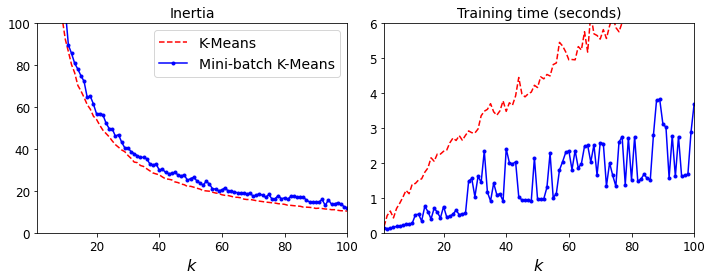

In [58]:
plt.figure(figsize=(10,4))

# 왼편 그림
plt.subplot(121)

plt.plot(range(1, 101), inertias[:, 0], "r--", label="K-Means")            # 빨강 파선
plt.plot(range(1, 101), inertias[:, 1], "b.-", label="Mini-batch K-Means") # 파랑 실선

plt.xlabel("$k$", fontsize=16)
plt.title("Inertia", fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

# 오른편 그림
plt.subplot(122)

plt.plot(range(1, 101), times[:, 0], "r--", label="K-Means")            # 빨강 파선
plt.plot(range(1, 101), times[:, 1], "b.-", label="Mini-batch K-Means") # 파랑 실선

plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
plt.axis([1, 100, 0, 6])

save_fig("minibatch_kmeans_vs_kmeans")
plt.show()

### 최적의 군집수

지금까지 사용한 예제에 대해 군집수를 5보다 작거나 크게 하면 아래와 같은 일이 발생한다.

Saving figure bad_n_clusters_plot


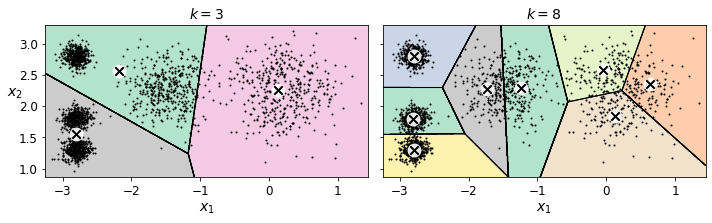

In [60]:
kmeans_k3 = KMeans(n_clusters=3, random_state=42)  # 3개의 군집
kmeans_k8 = KMeans(n_clusters=8, random_state=42)  # 8개의 군집

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
save_fig("bad_n_clusters_plot")
plt.show()

#### 관성 활용

별로 좋아보이지 않는다. 
그런데 관성은 군집수가 커질수록 줄어든다.

In [61]:
kmeans_k3.inertia_

653.2167190021556

In [62]:
kmeans_k8.inertia_

119.11983416102888

실제로 군집수가 많아질 수록 관성은 줄어든다. 
이유는 센트로이드 수가 늘어날 수록 각 샘플과 센트로이드 사이의 거리는 줄어들 수밖에 없기 때문이다. 
아래 코드가 이 사실을 잘 보여준다.

* $k$가 1부터 9까지 변하는 동안 훈련된 모델의 관성을 측정한다.

In [63]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

* 군집수와 측정된 관성 사이의 관계를 선그래프로 그리면 다음과 같다.

Saving figure inertia_vs_k_plot


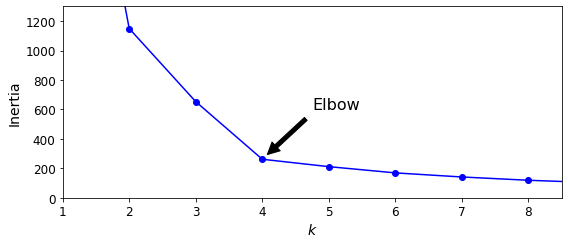

In [64]:
plt.figure(figsize=(8, 3.5))

# 군집수와 관성 관계
plt.plot(range(1, 10), inertias, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

# 주석 작성: Elbow 단어와 화살표 표시
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )

plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_plot")
plt.show()

팔꿈치(elbow)에 해당하는 위치인 $k=4$, 즉, 네 개의 군집이 좋아 보인다.
군집이 네 개보다 작으면 별로이고, 4개보다 많아도 별로 좋아지지 않아 보인다. 
하지만 아래 그림에서 볼 수 있듯이 왼쪽 하단 두 개의 군집이 하나의 군집으로 처리되기 때문이다.
그럼에도 불구하고 꽤 좋은 군집화 모델임엔 틀림없다. 

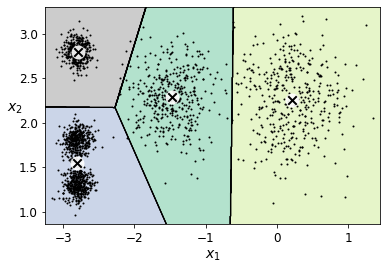

In [65]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.show()

#### 실루엣 점수 활용

__실루엣 점수__(silhouette score)는 각 훈련 샘플에 대한 
__실루엣 계수__(silhouette coefficient)의 평균값이다. 
실루엣 계수는 아래와 같이 계산된다.

$$\frac{b - a}{\max(a, b)}$$

* $a$: 동일 군집 내의 다른 샘플과의 거리의 평균값
* $b$: 가장 가까운 타 군집 샘플과의 거리의 평균값

실루엣 계수는 -1과 1 사이의 값이며, 의미는 다음과 같다.

* 1에 가까울 때: 해당 인스턴스가 속하는 군집의 한 센트로이드에 가깝게 위치함.
* 0에 가까울 때: 해당 인스턴스가 속하는 군집의 경계에 가깝게 위치함.
* -1에 가까울 때: 해당 인스턴스가 속하는 군집이 아닌 다른 군집의 센트로이드에 가깝게 위치함.
    즉, 잘못된 군집에 속함.

아래 코드는 군집수가 증가할 때 실루엣 점수의 변화를 보여준다.

In [66]:
from sklearn.metrics import silhouette_score

In [67]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_plot


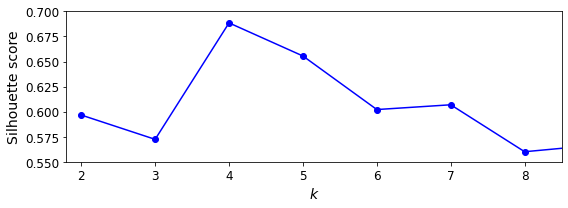

In [68]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")

plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
save_fig("silhouette_score_vs_k_plot")
plt.show()

$k=4$가 여전히 매우 좋아 보인다. 
하지만 관성의 경우와는 달리 $k=5$도 역시 꽤 좋다는 것을 알 수 있다. 

군집별로 각 샘플의 실루엣 계수를 오름차순으로 정렬한 그래프인 
__실루엣 다이어그램__(silhouette diagram)이
보다 많은 정보를 전달한다.

Saving figure silhouette_analysis_plot


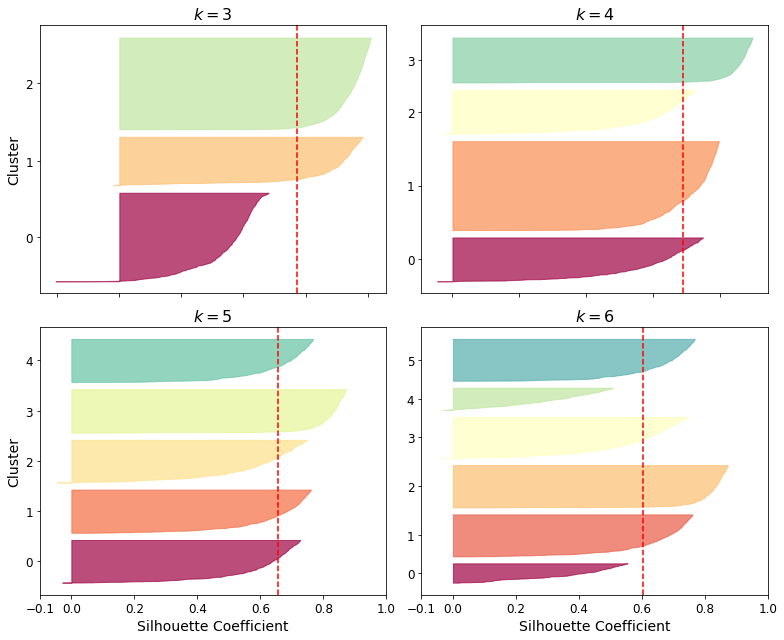

In [69]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(11, 9))

for k in (3, 4, 5, 6):
    plt.subplot(2, 2, k - 2)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

save_fig("silhouette_analysis_plot")
plt.show()

$k=5$인 경우가 가장 좋아 보인다.
이유는 모든 군집이 거의 비슷한 크기이고, 모든 군집의 칼날이 실루엣 점수(빨강 파선)넘어서고 있기 때문이다.

### 9.1.2 k-평균의 한계

k-평균의 가장 큰 단점은 최적의 군집수를 확인하기 위해 알고리즘을 여러 번 실행해야 한다는 점이다. 
또한 군집의 크기와 밀도가 서로 다른거나 원형이 아닌 경우 k-평균 모델이 제대로 작동하지 않을 수 있다. 

아래 코드는 타원 모양의 군집으로 이루어진 데이터셋을 생성한다.

In [70]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

산점도를 그리면 아래와 같다.

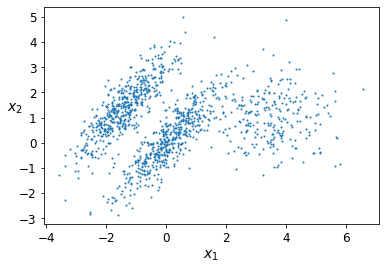

In [71]:
plot_clusters(X)

먼저 알고 있는 센트로이드 정보를 이용하여 좋은 k-평균 모델을 훈련한다.

In [72]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]), n_init=1, random_state=42)
kmeans_good.fit(X)

KMeans(init=array([[-1.5,  2.5],
       [ 0.5,  0. ],
       [ 4. ,  0. ]]),
       n_clusters=3, n_init=1, random_state=42)

이번엔 센트로이드를 무작위로 지정한다. 

In [73]:
kmeans_bad = KMeans(n_clusters=3, random_state=42)
kmeans_bad.fit(X)

KMeans(n_clusters=3, random_state=42)

두 모델의 훈련 결과는 다음과 같다. 
오른편 모델은 형편없다. 
반면에 왼편 모델은 보다 좋지만 그래도 25%정도의 데이터가 
오른쪽 군집에 잘못 할당되었다.

Saving figure bad_kmeans_plot


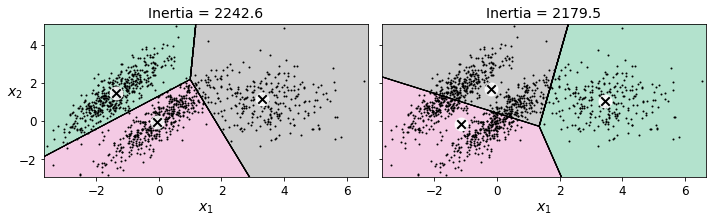

In [74]:
plt.figure(figsize=(10, 3.2))

plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title("Inertia = {:.1f}".format(kmeans_good.inertia_), fontsize=14)

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans_bad.inertia_), fontsize=14)

save_fig("bad_kmeans_plot")
plt.show()

#### 특성 스케일링 활용

특성 스케일링을 하면 군집 구분이 보다 명확해지고 보다 원형에 가까운 군집이 생성되어
k-평균 모델의 성능이 보다 좋아질 수 있다.

### 9.1.3 군집화 활용: 이미지 색상 분할

이미지 색상 분할은 유사한 색상을 동일한 군집에 연결하는 기법을 의미한다. 
색상 분할 과정을 살펴보기 위해 무당벌레 이미지를 하나 다운로드한다.

In [75]:
# 무당벌레 이미지 다운로드
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"

filename = "ladybug.png"
print("Downloading", filename)

url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/unsupervised_learning/ladybug.png',
 <http.client.HTTPMessage at 0x7fab72920a50>)

다운로드된 이미지는 `533 x 800` 픽셀 크기의 칼라 사진이다. 

In [78]:
from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))

image.shape

(533, 800, 3)

k-평균 모델 훈련을 위해 이미지 픽셀을 일차원으로 변환한다.
즉, `(533, 800, 3)` 모양의 어레이를 `(426400, 3)` 모양의 어레이로 변환한다.

__참고:__ `533 * 800 = 426,400`

In [87]:
X = image.reshape(-1, 3)
X.shape

(426400, 3)

#### 이미지 색상 분할 과정

아래 코드는 8개의 군집을 이용한 색상 분할과정을 보여준다. 
먼저, k-평균 모델을 설정한다. 

- `n_clusters=8`: 8개의 군집 사용

In [79]:
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

찾아낸 8개의 센트로이드는 다음과 같다.

In [81]:
kmeans.cluster_centers_

array([[0.98352236, 0.93586105, 0.02574842],
       [0.02288038, 0.11069143, 0.00578684],
       [0.21914423, 0.3867576 , 0.05800591],
       [0.75786924, 0.21211298, 0.04458136],
       [0.09991632, 0.25424522, 0.01694096],
       [0.61266166, 0.63010174, 0.38750774],
       [0.3721264 , 0.52358615, 0.15729988],
       [0.8845285 , 0.72554106, 0.03442959]], dtype=float32)

각 훈련 샘플에 대한 레이블(`kmeans.labels_`)을 이용하여 군집별 센트로이드의 색상으로 통일시킨다. 
이를 위해 넘파이 어레이에 대한 팬시 인덱싱을 활용한다.

In [90]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_]

이미지를 원래의 크기로 다시 변환한다. 

In [91]:
segmented_img = segmented_img.reshape(image.shape)

#### 군집수에 따른 비교

아래 코드는 앞서 설명한 방식을 다양한 군집수에 대해 적용한 결과를 비교할 수 있는 그림을 보여준다.

- 5종류의 군집수를 이용한 이미지 색상 분할

In [92]:
segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)

for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

- 원본 이미지와 군집화를 활용한 5개의 이미지 비교
    - 군집수가 적어질 수록 작은 무당벌레의 색상을 다른 군집과 연결하기에 무당벌레 색상이 점차 사라짐.

Saving figure image_segmentation_diagram


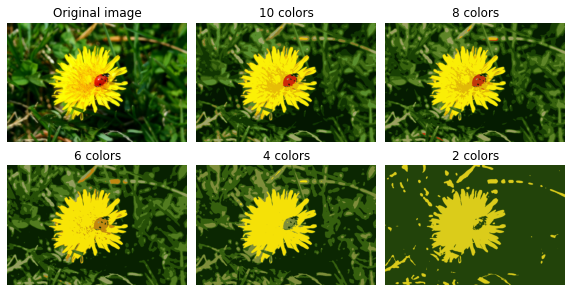

In [93]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

# 원본 이미지
plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

# 색상 분할된 이미지 5개
for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

save_fig('image_segmentation_diagram', tight_layout=False)
plt.show()

### 9.1.4 군집화 활용: 차원축소

훈련된 k-평균 객체의 `transform()` 메서드는 주어진 데이터에 대해 각 센트로이드부터의 거리로 이루어진
어레이를 생성한다.
즉, `n` 차원의 데이터셋을 `k` 차원의 데이터셋으로 변환한다.
만약에 `k < n` 이라면 이는 비선형 차원축소로 간주될 수 있으며 이어지는 지도학습에
유용하게 활용될 수 있다.

여기서는 MNIST 손글씨 데이터셋을 이용하여 군집화를 차원축소 기법으로 활용하는 방식을 소개한다.
다만, 여기서 사용되는 데이터셋은 `8 x 8` 크기의 픽셀을 갖는 1,797개의 축소된 MNIST 데이터셋을 사용한다.

In [107]:
from sklearn.datasets import load_digits

X_digits, y_digits = load_digits(return_X_y=True)

먼저 훈련 세트와 테스트 세트로 구분한다.

In [108]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

#### 로지스틱 회귀 적용

로지스틱 회귀 모델을 훈련한 다음에 테스트 세트에 대한 성능을 평가하면, 정확도 평균값이 96.9% 정도로 나온다.

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [111]:
log_reg.score(X_test, y_test)

0.9688888888888889

#### 군집화 전처리 후 성능 평가

아래 파이프라인은 50개의 군집으로 먼저 군집화를 한 다음에 로지스틱 회귀 모델을 훈련한다. 

__주의사항:__ 파이파라인으로 구성된 예측기의 `fit()` 메서드를 호출하면
최종 예측기를 제외한 나머지 예측기의 `fit_transform()` 메서드가 호출된다.
또한 k-평균 모델의 `transform()` 메서드는 앞서 설명한 방식으로 차원축소를 진행한다.

In [112]:
from sklearn.pipeline import Pipeline

In [113]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('kmeans', KMeans(n_clusters=50, random_state=42)),
                ('log_reg',
                 LogisticRegression(max_iter=5000, multi_class='ovr',
                                    random_state=42))])

파이프라인 모델의 정확도 평균값은 97.7%로 28%의 성능향상이 발생한다.

In [114]:
pipeline.score(X_test, y_test)

0.9777777777777777

In [115]:
1 - (1 - 0.977777) / (1 - 0.968888)

0.28570969400874346

#### 그리드 탐색 활용

그리드 탐색을 이용하여 최적의 군집수를 알아낼 수 있다. 
즉, 파이프라인의 성능이 최고가 되도록 하는 군집수는 다음과 같다.

아래 코드는 그리드 참색을 이용하여 2개부터 100개 사이의 군집을 사용할 때
이어지는 로지스틱 회귀의 성능을 평가하여 최적의 군집수를 알아낸다.

**경고**: 사용하는 컴퓨터 성능에 따라 아래 코드는 20분 이상 걸릴 수 있다.

In [120]:
from sklearn.model_selection import GridSearchCV

In [90]:
param_grid = dict(kmeans__n_clusters=range(2, 100))
grid_clf = GridSearchCV(pipeline, param_grid, cv=3, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 3 folds for each of 98 candidates, totalling 294 fits
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=2 ............................................
[CV] ............................. kmeans__n_clusters=2, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=3 ............................................
[CV] ............................. kmeans__n_clusters=3, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.1s
[CV] kmeans__n_clusters=4 ............................................
[CV] ............................. kmeans__n_clusters=4, total=   0.2s
[CV] kmeans__n_clusters=4 ............................................
[CV] .

[CV] ............................ kmeans__n_clusters=21, total=   1.5s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.7s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.6s
[CV] kmeans__n_clusters=22 ...........................................
[CV] ............................ kmeans__n_clusters=22, total=   1.7s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.8s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.8s
[CV] kmeans__n_clusters=23 ...........................................
[CV] ............................ kmeans__n_clusters=23, total=   1.7s
[CV] kmeans__n_clusters=24 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=41, total=   2.5s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   2.3s
[CV] kmeans__n_clusters=41 ...........................................
[CV] ............................ kmeans__n_clusters=41, total=   2.5s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.6s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.3s
[CV] kmeans__n_clusters=42 ...........................................
[CV] ............................ kmeans__n_clusters=42, total=   2.4s
[CV] kmeans__n_clusters=43 ...........................................
[CV] ............................ kmeans__n_clusters=43, total=   2.6s
[CV] kmeans__n_clusters=43 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=60, total=   2.8s
[CV] kmeans__n_clusters=60 ...........................................
[CV] ............................ kmeans__n_clusters=60, total=   2.6s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.8s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   3.1s
[CV] kmeans__n_clusters=61 ...........................................
[CV] ............................ kmeans__n_clusters=61, total=   2.4s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   3.0s
[CV] kmeans__n_clusters=62 ...........................................
[CV] ............................ kmeans__n_clusters=62, total=   2.7s
[CV] kmeans__n_clusters=62 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=79, total=   2.9s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.4s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   3.1s
[CV] kmeans__n_clusters=80 ...........................................
[CV] ............................ kmeans__n_clusters=80, total=   2.8s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.9s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   3.5s
[CV] kmeans__n_clusters=81 ...........................................
[CV] ............................ kmeans__n_clusters=81, total=   2.9s
[CV] kmeans__n_clusters=82 ...........................................
[CV] .

[CV] ............................ kmeans__n_clusters=99, total=   2.6s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   2.8s
[CV] kmeans__n_clusters=99 ...........................................
[CV] ............................ kmeans__n_clusters=99, total=   3.0s


[Parallel(n_jobs=1)]: Done 294 out of 294 | elapsed: 10.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kmeans',
                                        KMeans(n_clusters=50, random_state=42)),
                                       ('log_reg',
                                        LogisticRegression(max_iter=5000,
                                                           multi_class='ovr',
                                                           random_state=42))]),
             param_grid={'kmeans__n_clusters': range(2, 100)}, verbose=2)

최적의 군집수는 57이며, 로지스틱 회귀의 정확도는 98%가 된다.

In [91]:
grid_clf.best_params_

{'kmeans__n_clusters': 57}

In [92]:
grid_clf.score(X_test, y_test)

0.98

### 9.1.5 군집화 활용: 준지도학습

Another use case for clustering is in semi-supervised learning, when we have plenty of unlabeled instances and very few labeled instances.

Let's look at the performance of a logistic regression model when we only have 50 labeled instances:

In [93]:
n_labeled = 50

In [94]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", random_state=42)
log_reg.fit(X_train[:n_labeled], y_train[:n_labeled])
log_reg.score(X_test, y_test)

0.8333333333333334

It's much less than earlier of course. Let's see how we can do better. First, let's cluster the training set into 50 clusters, then for each cluster let's find the image closest to the centroid. We will call these images the representative images:

In [95]:
k = 50

In [96]:
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

Now let's plot these representative images and label them manually:

Saving figure representative_images_diagram


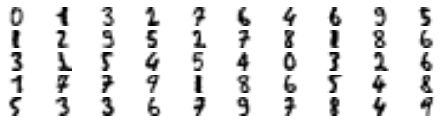

In [97]:
plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

save_fig("representative_images_diagram", tight_layout=False)
plt.show()

In [98]:
y_train[representative_digit_idx]

array([0, 1, 3, 2, 7, 6, 4, 6, 9, 5, 1, 2, 9, 5, 2, 7, 8, 1, 8, 6, 3, 1,
       5, 4, 5, 4, 0, 3, 2, 6, 1, 7, 7, 9, 1, 8, 6, 5, 4, 8, 5, 3, 3, 6,
       7, 9, 7, 8, 4, 9])

In [99]:
y_representative_digits = y_train[representative_digit_idx]

Now we have a dataset with just 50 labeled instances, but instead of being completely random instances, each of them is a representative image of its cluster. Let's see if the performance is any better:

In [100]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.9244444444444444

Wow! We jumped from 83.3% accuracy to 91.3%, although we are still only training the model on 50 instances. Since it's often costly and painful to label instances, especially when it has to be done manually by experts, it's a good idea to make them label representative instances rather than just random instances.

But perhaps we can go one step further: what if we propagated the labels to all the other instances in the same cluster?

In [101]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)

for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]

In [102]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [103]:
log_reg.score(X_test, y_test)

0.9377777777777778

We got a tiny little accuracy boost. Better than nothing, but we should probably have propagated the labels only to the instances closest to the centroid, because by propagating to the full cluster, we have certainly included some outliers. Let's only propagate the labels to the 20th percentile closest to the centroid:

In [104]:
percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

In [105]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [106]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [107]:
log_reg.score(X_test, y_test)

0.9222222222222223

A bit better. With just 50 labeled instances (just 5 examples per class on average!), we got 92.7% performance, which is getting closer to the performance of logistic regression on the fully labeled _digits_ dataset (which was 96.9%).

This is because the propagated labels are actually pretty good: their accuracy is close to 96%:

In [108]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9896193771626297

You could now do a few iterations of *active learning*:
1. Manually label the instances that the classifier is least sure about, if possible by picking them in distinct clusters.
2. Train a new model with these additional labels.

### 9.1.6 DBSCAN

In [109]:
from sklearn.datasets import make_moons

In [110]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [111]:
from sklearn.cluster import DBSCAN

In [112]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [113]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5], dtype=int64)

In [114]:
len(dbscan.core_sample_indices_)

808

In [115]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13], dtype=int64)

In [116]:
dbscan.components_[:3]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599]])

In [117]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6], dtype=int64)

In [118]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

In [119]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

Saving figure dbscan_plot


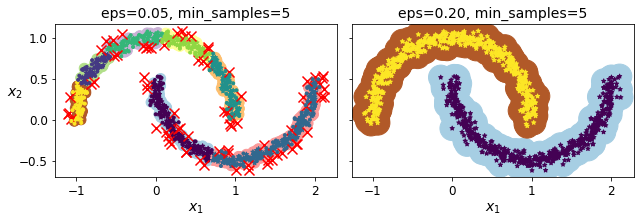

In [120]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

save_fig("dbscan_plot")
plt.show()


In [121]:
dbscan = dbscan2

In [122]:
from sklearn.neighbors import KNeighborsClassifier

In [123]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [124]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0], dtype=int64)

In [125]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Saving figure cluster_classification_plot


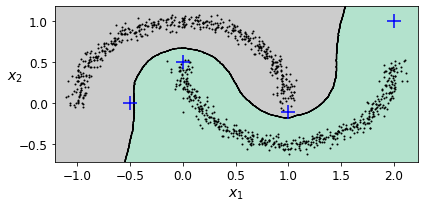

In [126]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="+", s=200, zorder=10)
save_fig("cluster_classification_plot")
plt.show()

In [127]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1], dtype=int64)

__주의사항:__ 저자의 주피터 노트북에 사용된 아래 코드는 정확하지 않음.
이유는 `dbscan.core_sample_indices_`가 전체 `dbscan.labels_` 가 아닌 경우
엉뚱한 답을 내 놓을 수도 있기 때문임.

```python
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()
```

### 9.1.7 기타 군집화 알고리즘

#### 스펙트럴 군집화(Spectral Clustering)

In [128]:
from sklearn.cluster import SpectralClustering

In [129]:
sc1 = SpectralClustering(n_clusters=2, gamma=100, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=100, n_clusters=2, random_state=42)

In [130]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [131]:
np.percentile(sc1.affinity_matrix_, 95)

0.04251990648936265

In [132]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True, show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', cmap="Paired", alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("RBF gamma={}".format(sc.gamma), fontsize=14)

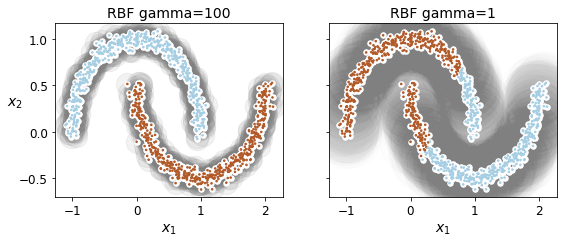

In [133]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()


#### 응집 군집화(Agglomerative Clustering)

In [134]:
from sklearn.cluster import AgglomerativeClustering

In [135]:
X = np.array([0, 2, 5, 8.5]).reshape(-1, 1)
agg = AgglomerativeClustering(linkage="complete").fit(X)

In [136]:
def learned_parameters(estimator):
    return [attrib for attrib in dir(estimator)
            if attrib.endswith("_") and not attrib.startswith("_")]

In [137]:
learned_parameters(agg)

['children_',
 'labels_',
 'n_clusters_',
 'n_connected_components_',
 'n_features_in_',
 'n_leaves_']

In [138]:
agg.children_

array([[0, 1],
       [2, 3],
       [4, 5]])

## 9.2 가우시안 혼합(Gaussian Mixtures)

In [139]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

Let's train a Gaussian mixture model on the previous dataset:

In [140]:
from sklearn.mixture import GaussianMixture

In [141]:
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=3, n_init=10, random_state=42)

Let's look at the parameters that the EM algorithm estimated:

In [142]:
gm.weights_

array([0.39054348, 0.2093669 , 0.40008962])

In [143]:
gm.means_

array([[ 0.05224874,  0.07631976],
       [ 3.40196611,  1.05838748],
       [-1.40754214,  1.42716873]])

In [144]:
gm.covariances_

array([[[ 0.6890309 ,  0.79717058],
        [ 0.79717058,  1.21367348]],

       [[ 1.14296668, -0.03114176],
        [-0.03114176,  0.9545003 ]],

       [[ 0.63496849,  0.7298512 ],
        [ 0.7298512 ,  1.16112807]]])

Did the algorithm actually converge?

In [145]:
gm.converged_

True

Yes, good. How many iterations did it take?

In [146]:
gm.n_iter_

4

You can now use the model to predict which cluster each instance belongs to (hard clustering) or the probabilities that it came from each cluster. For this, just use `predict()` method or the `predict_proba()` method:

In [147]:
gm.predict(X)

array([0, 0, 2, ..., 1, 1, 1], dtype=int64)

In [148]:
gm.predict_proba(X)

array([[9.77227791e-01, 2.27715290e-02, 6.79898914e-07],
       [9.83288385e-01, 1.60345103e-02, 6.77104389e-04],
       [7.51824662e-05, 1.90251273e-06, 9.99922915e-01],
       ...,
       [4.35053542e-07, 9.99999565e-01, 2.17938894e-26],
       [5.27837047e-16, 1.00000000e+00, 1.50679490e-41],
       [2.32355608e-15, 1.00000000e+00, 8.21915701e-41]])

This is a generative model, so you can sample new instances from it (and get their labels):

In [149]:
X_new, y_new = gm.sample(6)
X_new

array([[-0.8690223 , -0.32680051],
       [ 0.29945755,  0.2841852 ],
       [ 1.85027284,  2.06556913],
       [ 3.98260019,  1.50041446],
       [ 3.82006355,  0.53143606],
       [-1.04015332,  0.7864941 ]])

In [150]:
y_new

array([0, 0, 1, 1, 1, 2])

Notice that they are sampled sequentially from each cluster.

You can also estimate the log of the _probability density function_ (PDF) at any location using the `score_samples()` method:

In [151]:
gm.score_samples(X)

array([-2.60674489, -3.57074133, -3.33007348, ..., -3.51379355,
       -4.39643283, -3.8055665 ])

Let's check that the PDF integrates to 1 over the whole space. We just take a large square around the clusters, and chop it into a grid of tiny squares, then we compute the approximate probability that the instances will be generated in each tiny square (by multiplying the PDF at one corner of the tiny square by the area of the square), and finally summing all these probabilities). The result is very close to 1:

In [152]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
pdf_probas.sum()

0.9999999999271592

Now let's plot the resulting decision boundaries (dashed lines) and density contours:

In [153]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure gaussian_mixtures_plot


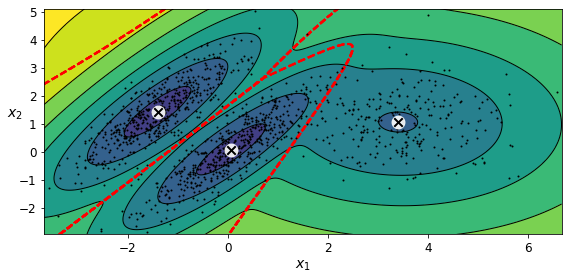

In [154]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)

save_fig("gaussian_mixtures_plot")
plt.show()

You can impose constraints on the covariance matrices that the algorithm looks for by setting the `covariance_type` hyperparameter:
* `"full"` (default): no constraint, all clusters can take on any ellipsoidal shape of any size.
* `"tied"`: all clusters must have the same shape, which can be any ellipsoid (i.e., they all share the same covariance matrix).
* `"spherical"`: all clusters must be spherical, but they can have different diameters (i.e., different variances).
* `"diag"`: clusters can take on any ellipsoidal shape of any size, but the ellipsoid's axes must be parallel to the axes (i.e., the covariance matrices must be diagonal).

In [155]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=3, n_init=10,
                random_state=42)

In [156]:
def compare_gaussian_mixtures(gm1, gm2, X):
    plt.figure(figsize=(9, 4))

    plt.subplot(121)
    plot_gaussian_mixture(gm1, X)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)

    plt.subplot(122)
    plot_gaussian_mixture(gm2, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)


Saving figure covariance_type_plot


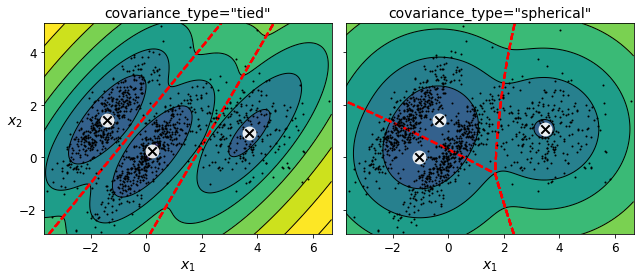

In [157]:
compare_gaussian_mixtures(gm_tied, gm_spherical, X)

save_fig("covariance_type_plot")
plt.show()

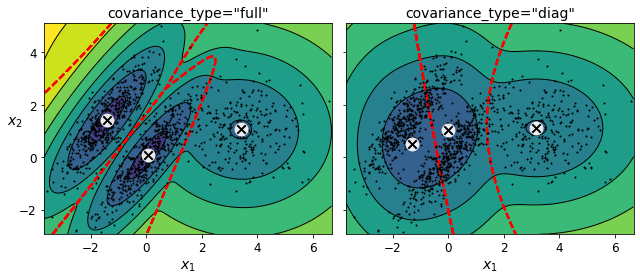

In [158]:
compare_gaussian_mixtures(gm_full, gm_diag, X)
plt.tight_layout()
plt.show()

### 9.2.1 가우시안 혼합과 이상치 탐지

Gaussian Mixtures can be used for _anomaly detection_: instances located in low-density regions can be considered anomalies. You must define what density threshold you want to use. For example, in a manufacturing company that tries to detect defective products, the ratio of defective products is usually well-known. Say it is equal to 4%, then you can set the density threshold to be the value that results in having 4% of the instances located in areas below that threshold density:

In [159]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

Saving figure mixture_anomaly_detection_plot


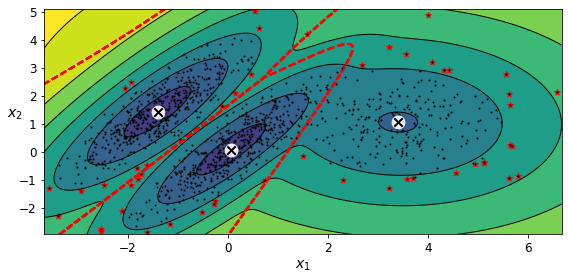

In [160]:
plt.figure(figsize=(8, 4))

plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)

save_fig("mixture_anomaly_detection_plot")
plt.show()

### 9.2.2 모델 선택

We cannot use the inertia or the silhouette score because they both assume that the clusters are spherical. Instead, we can try to find the model that minimizes a theoretical information criterion such as the Bayesian Information Criterion (BIC) or the Akaike Information Criterion (AIC):

${BIC} = {\log(m)p - 2\log({\hat L})}$

${AIC} = 2p - 2\log(\hat L)$

* $m$ is the number of instances.
* $p$ is the number of parameters learned by the model.
* $\hat L$ is the maximized value of the likelihood function of the model. This is the conditional probability of the observed data $\mathbf{X}$, given the model and its optimized parameters.

Both BIC and AIC penalize models that have more parameters to learn (e.g., more clusters), and reward models that fit the data well (i.e., models that give a high likelihood to the observed data).

In [161]:
gm.bic(X)

8189.662685850679

In [162]:
gm.aic(X)

8102.437405735641

We could compute the BIC manually like this:

In [163]:
n_clusters = 3
n_dims = 2
n_params_for_weights = n_clusters - 1
n_params_for_means = n_clusters * n_dims
n_params_for_covariance = n_clusters * n_dims * (n_dims + 1) // 2
n_params = n_params_for_weights + n_params_for_means + n_params_for_covariance
max_log_likelihood = gm.score(X) * len(X) # log(L^)
bic = np.log(len(X)) * n_params - 2 * max_log_likelihood
aic = 2 * n_params - 2 * max_log_likelihood

In [164]:
bic, aic

(8189.662685850679, 8102.437405735641)

In [165]:
n_params

17

There's one weight per cluster, but the sum must be equal to 1, so we have one degree of freedom less, hence the -1. Similarly, the degrees of freedom for an $n \times n$ covariance matrix is not $n^2$, but $1 + 2 + \dots + n = \dfrac{n (n+1)}{2}$.

Let's train Gaussian Mixture models with various values of $k$ and measure their BIC:

In [166]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X)
             for k in range(1, 11)]

In [167]:
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

Saving figure aic_bic_vs_k_plot


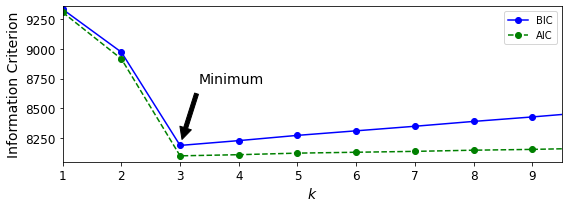

In [168]:
plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
save_fig("aic_bic_vs_k_plot")
plt.show()

Let's search for best combination of values for both the number of clusters and the `covariance_type` hyperparameter:

In [169]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

In [170]:
best_k

3

In [171]:
best_covariance_type

'full'

### 9.2.3 베이즈 가우시안 혼합 모델

Rather than manually searching for the optimal number of clusters, it is possible to use instead the `BayesianGaussianMixture` class which is capable of giving weights equal (or close) to zero to unnecessary clusters. Just set the number of components to a value that you believe is greater than the optimal number of clusters, and the algorithm will eliminate the unnecessary clusters automatically.

In [172]:
from sklearn.mixture import BayesianGaussianMixture

In [173]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

C:\Users\gslee\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

The algorithm automatically detected that only 3 components are needed:

In [174]:
np.round(bgm.weights_, 2)

array([0.4 , 0.  , 0.  , 0.  , 0.39, 0.2 , 0.  , 0.  , 0.  , 0.  ])

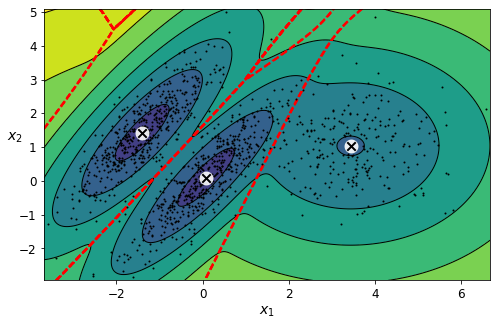

In [175]:
plt.figure(figsize=(8, 5))
plot_gaussian_mixture(bgm, X)
plt.show()

In [176]:
bgm_low = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=0.01, random_state=42)
bgm_high = BayesianGaussianMixture(n_components=10, max_iter=1000, n_init=1,
                                  weight_concentration_prior=10000, random_state=42)
nn = 73
bgm_low.fit(X[:nn])
bgm_high.fit(X[:nn])

BayesianGaussianMixture(max_iter=1000, n_components=10, random_state=42,
                        weight_concentration_prior=10000)

In [177]:
np.round(bgm_low.weights_, 2)

array([0.49, 0.51, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [178]:
np.round(bgm_high.weights_, 2)

array([0.43, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01, 0.37, 0.01, 0.01])

Saving figure mixture_concentration_prior_plot


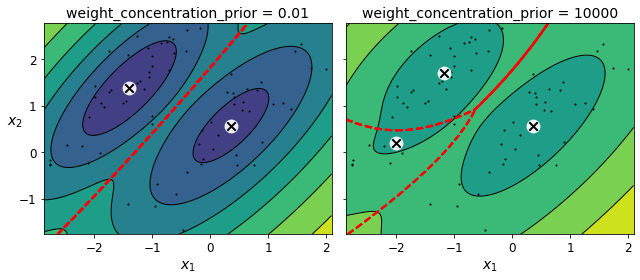

In [179]:
plt.figure(figsize=(9, 4))

plt.subplot(121)
plot_gaussian_mixture(bgm_low, X[:nn])
plt.title("weight_concentration_prior = 0.01", fontsize=14)

plt.subplot(122)
plot_gaussian_mixture(bgm_high, X[:nn], show_ylabels=False)
plt.title("weight_concentration_prior = 10000", fontsize=14)

save_fig("mixture_concentration_prior_plot")
plt.show()

Note: the fact that you see only 3 regions in the right plot although there are 4 centroids is not a bug. The weight of the top-right cluster is much larger than the weight of the lower-right cluster, so the probability that any given point in this region belongs to the top right cluster is greater than the probability that it belongs to the lower-right cluster.

In [180]:
X_moons, y_moons = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [181]:
bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X_moons)

BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)

Saving figure moons_vs_bgm_plot


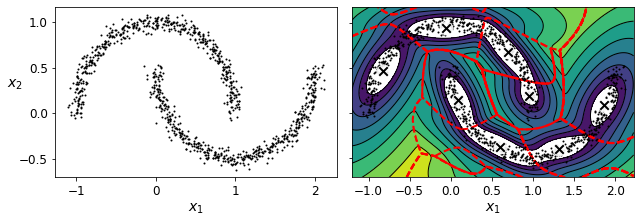

In [182]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_data(X_moons)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.subplot(122)
plot_gaussian_mixture(bgm, X_moons, show_ylabels=False)

save_fig("moons_vs_bgm_plot")
plt.show()

Oops, not great... instead of detecting 2 moon-shaped clusters, the algorithm detected 8 ellipsoidal clusters. However, the density plot does not look too bad, so it might be usable for anomaly detection.

### 가능도(likelihood) 함수

In [183]:
from scipy.stats import norm

In [184]:
xx = np.linspace(-6, 4, 101)
ss = np.linspace(1, 2, 101)
XX, SS = np.meshgrid(xx, ss)
ZZ = 2 * norm.pdf(XX - 1.0, 0, SS) + norm.pdf(XX + 4.0, 0, SS)
ZZ = ZZ / ZZ.sum(axis=1)[:,np.newaxis] / (xx[1] - xx[0])

Saving figure likelihood_function_plot


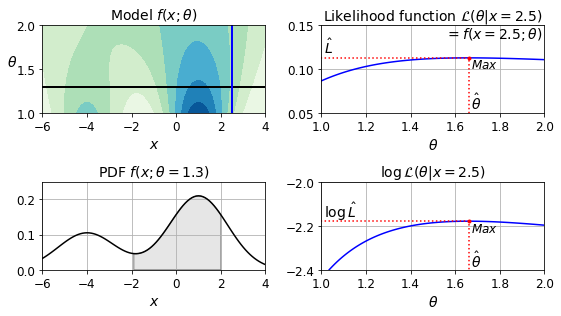

In [185]:
from matplotlib.patches import Polygon

plt.figure(figsize=(8, 4.5))

x_idx = 85
s_idx = 30

plt.subplot(221)
plt.contourf(XX, SS, ZZ, cmap="GnBu")
plt.plot([-6, 4], [ss[s_idx], ss[s_idx]], "k-", linewidth=2)
plt.plot([xx[x_idx], xx[x_idx]], [1, 2], "b-", linewidth=2)
plt.xlabel(r"$x$")
plt.ylabel(r"$\theta$", fontsize=14, rotation=0)
plt.title(r"Model $f(x; \theta)$", fontsize=14)

plt.subplot(222)
plt.plot(ss, ZZ[:, x_idx], "b-")
max_idx = np.argmax(ZZ[:, x_idx])
max_val = np.max(ZZ[:, x_idx])
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [0, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.text(1.01, max_val + 0.005, r"$\hat{L}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, 0.055, r"$\hat{\theta}$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.012, r"$Max$", fontsize=12)
plt.axis([1, 2, 0.05, 0.15])
plt.xlabel(r"$\theta$", fontsize=14)
plt.grid(True)
plt.text(1.99, 0.135, r"$=f(x=2.5; \theta)$", fontsize=14, ha="right")
plt.title(r"Likelihood function $\mathcal{L}(\theta|x=2.5)$", fontsize=14)

plt.subplot(223)
plt.plot(xx, ZZ[s_idx], "k-")
plt.axis([-6, 4, 0, 0.25])
plt.xlabel(r"$x$", fontsize=14)
plt.grid(True)
plt.title(r"PDF $f(x; \theta=1.3)$", fontsize=14)
verts = [(xx[41], 0)] + list(zip(xx[41:81], ZZ[s_idx, 41:81])) + [(xx[80], 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
plt.gca().add_patch(poly)

plt.subplot(224)
plt.plot(ss, np.log(ZZ[:, x_idx]), "b-")
max_idx = np.argmax(np.log(ZZ[:, x_idx]))
max_val = np.max(np.log(ZZ[:, x_idx]))
plt.plot(ss[max_idx], max_val, "r.")
plt.plot([ss[max_idx], ss[max_idx]], [-5, max_val], "r:")
plt.plot([0, ss[max_idx]], [max_val, max_val], "r:")
plt.axis([1, 2, -2.4, -2])
plt.xlabel(r"$\theta$", fontsize=14)
plt.text(ss[max_idx]+ 0.01, max_val - 0.05, r"$Max$", fontsize=12)
plt.text(ss[max_idx]+ 0.01, -2.39, r"$\hat{\theta}$", fontsize=14)
plt.text(1.01, max_val + 0.02, r"$\log \, \hat{L}$", fontsize=14)
plt.grid(True)
plt.title(r"$\log \, \mathcal{L}(\theta|x=2.5)$", fontsize=14)

save_fig("likelihood_function_plot")
plt.show()

## 연습문제

## 1. to 9.

부록 A 참조

## 10. Cluster the Olivetti Faces Dataset

*Exercise: The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces. Each image is flattened to a 1D vector of size 4,096. 40 different people were photographed (10 times each), and the usual task is to train a model that can predict which person is represented in each picture. Load the dataset using the `sklearn.datasets.fetch_olivetti_faces()` function.*

In [186]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\gslee\scikit_learn_data


In [187]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

In [188]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

*Exercise: Then split it into a training set, a validation set, and a test set (note that the dataset is already scaled between 0 and 1). Since the dataset is quite small, you probably want to use stratified sampling to ensure that there are the same number of images per person in each set.*

In [189]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

In [190]:
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


To speed things up, we'll reduce the data's dimensionality using PCA:

In [191]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

*Exercise: Next, cluster the images using K-Means, and ensure that you have a good number of clusters (using one of the techniques discussed in this chapter).*

In [192]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


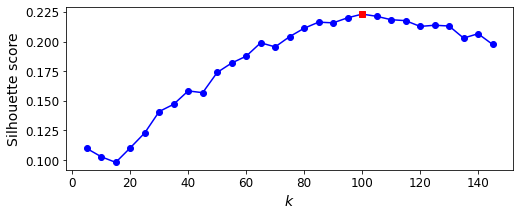

In [193]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

In [194]:
best_k

100

It looks like the best number of clusters is quite high, at 120. You might have expected it to be 40, since there are 40 different people on the pictures. However, the same person may look quite different on different pictures (e.g., with or without glasses, or simply shifted left or right).

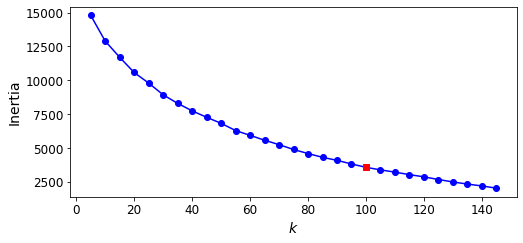

In [195]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

The optimal number of clusters is not clear on this inertia diagram, as there is no obvious elbow, so let's stick with k=100.

In [196]:
best_model = kmeans_per_k[best_index]

*Exercise: Visualize the clusters: do you see similar faces in each cluster?*

Cluster 0


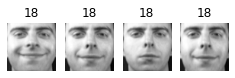

Cluster 1


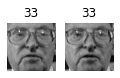

Cluster 2


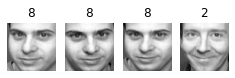

Cluster 3


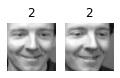

Cluster 4


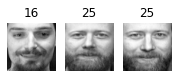

Cluster 5


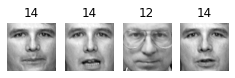

Cluster 6


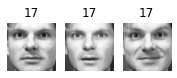

Cluster 7


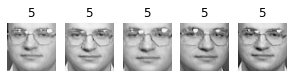

Cluster 8


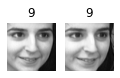

Cluster 9


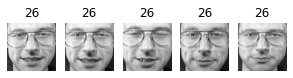

Cluster 10


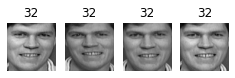

Cluster 11


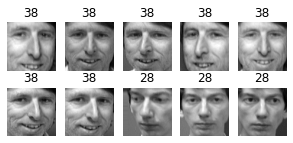

Cluster 12


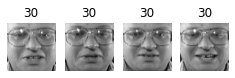

Cluster 13


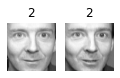

Cluster 14


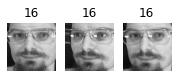

Cluster 15


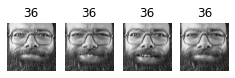

Cluster 16


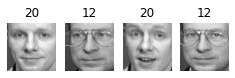

Cluster 17


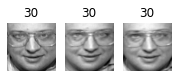

Cluster 18


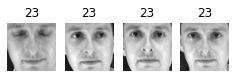

Cluster 19


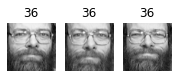

Cluster 20


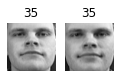

Cluster 21


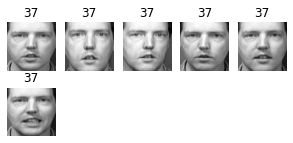

Cluster 22


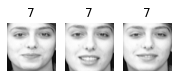

Cluster 23


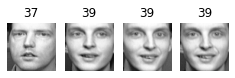

Cluster 24


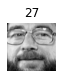

Cluster 25


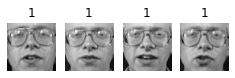

Cluster 26


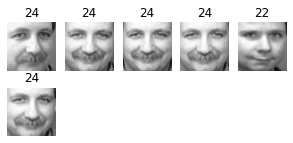

Cluster 27


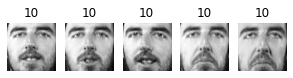

Cluster 28


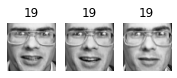

Cluster 29


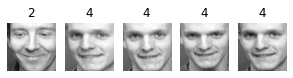

Cluster 30


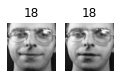

Cluster 31


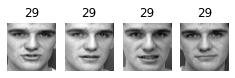

Cluster 32


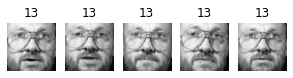

Cluster 33


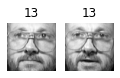

Cluster 34


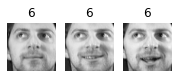

Cluster 35


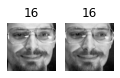

Cluster 36


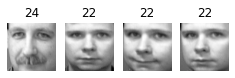

Cluster 37


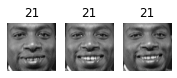

Cluster 38


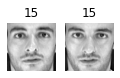

Cluster 39


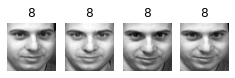

Cluster 40


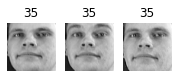

Cluster 41


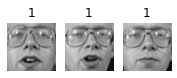

Cluster 42


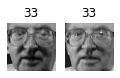

Cluster 43


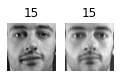

Cluster 44


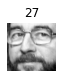

Cluster 45


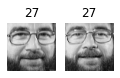

Cluster 46


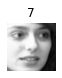

Cluster 47


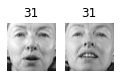

Cluster 48


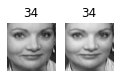

Cluster 49


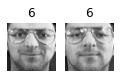

Cluster 50


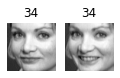

Cluster 51


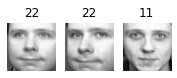

Cluster 52


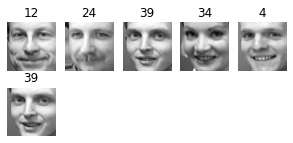

Cluster 53


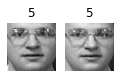

Cluster 54


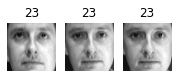

Cluster 55


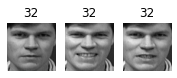

Cluster 56


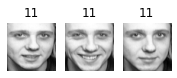

Cluster 57


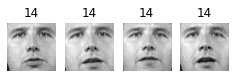

Cluster 58


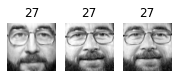

Cluster 59


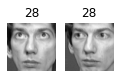

Cluster 60


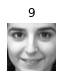

Cluster 61


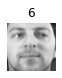

Cluster 62


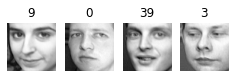

Cluster 63


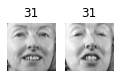

Cluster 64


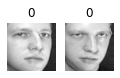

Cluster 65


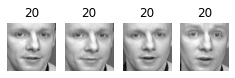

Cluster 66


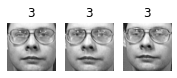

Cluster 67


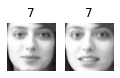

Cluster 68


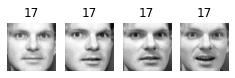

Cluster 69


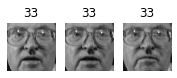

Cluster 70


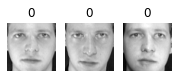

Cluster 71


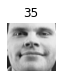

Cluster 72


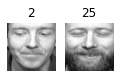

Cluster 73


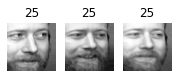

Cluster 74


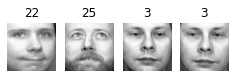

Cluster 75


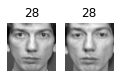

Cluster 76


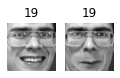

Cluster 77


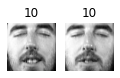

Cluster 78


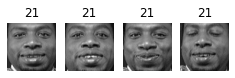

Cluster 79


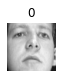

Cluster 80


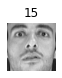

Cluster 81


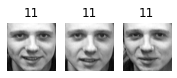

Cluster 82


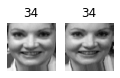

Cluster 83


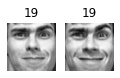

Cluster 84


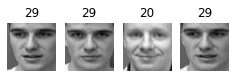

Cluster 85


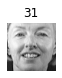

Cluster 86


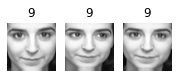

Cluster 87


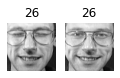

Cluster 88


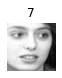

Cluster 89


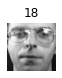

Cluster 90


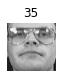

Cluster 91


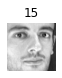

Cluster 92


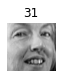

Cluster 93


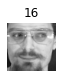

Cluster 94


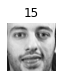

Cluster 95


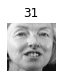

Cluster 96


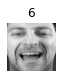

Cluster 97


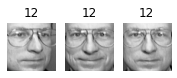

Cluster 98


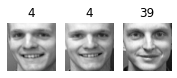

Cluster 99


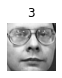

In [197]:
def plot_faces(faces, labels, n_cols=5):
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face.reshape(64, 64), cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster].reshape(-1, 64, 64)
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

About 2 out of 3 clusters are useful: that is, they contain at least 2 pictures, all of the same person. However, the rest of the clusters have either one or more intruders, or they have just a single picture.

Clustering images this way may be too imprecise to be directly useful when training a model (as we will see below), but it can be tremendously useful when labeling images in a new dataset: it will usually make labelling much faster.

## 11. Using Clustering as Preprocessing for Classification

*Exercise: Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented in each picture, and evaluate it on the validation set.*

In [198]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

*Exercise: Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.*

In [199]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.75

Yikes! That's not better at all! Let's see if tuning the number of clusters helps.

*Exercise: Search for the number of clusters that allows the classifier to get the best performance: what performance can you reach?*

We could use a `GridSearchCV` like we did earlier in this notebook, but since we already have a validation set, we don't need K-fold cross-validation, and we're only exploring a single hyperparameter, so it's simpler to just run a loop manually:

In [200]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.4125
10 0.525
15 0.5375
20 0.6375
25 0.65
30 0.6375
35 0.675
40 0.7375
45 0.725
50 0.75
55 0.7375
60 0.725
65 0.7375
70 0.725
75 0.725
80 0.775
85 0.7375
90 0.7375
95 0.75
100 0.75
105 0.75
110 0.7375
115 0.7375
120 0.75
125 0.75
130 0.725
135 0.75
140 0.7625
145 0.7375


Oh well, even by tuning the number of clusters, we never get beyond 80% accuracy. Looks like the distances to the cluster centroids are not as informative as the original images.

*Exercise: What if you append the features from the reduced set to the original features (again, searching for the best number of clusters)?*

In [201]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

In [202]:
clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.825

That's a bit better, but still worse than without the cluster features. The clusters are not useful to directly train a classifier in this case (but they can still help when labelling new training instances).

## 12. A Gaussian Mixture Model for the Olivetti Faces Dataset

*Exercise: Train a Gaussian mixture model on the Olivetti faces dataset. To speed up the algorithm, you should probably reduce the dataset's dimensionality (e.g., use PCA, preserving 99% of the variance).*

In [203]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

*Exercise: Use the model to generate some new faces (using the `sample()` method), and visualize them (if you used PCA, you will need to use its `inverse_transform()` method).*

In [204]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

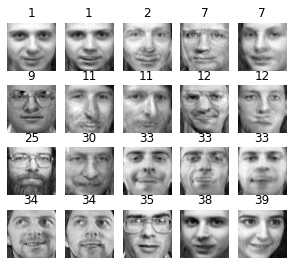

In [205]:
plot_faces(gen_faces, y_gen_faces)

*Exercise: Try to modify some images (e.g., rotate, flip, darken) and see if the model can detect the anomalies (i.e., compare the output of the `score_samples()` method for normal images and for anomalies).*

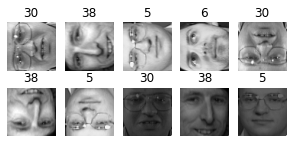

In [206]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
darkened = darkened.reshape(-1, 64*64)
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

In [207]:
X_bad_faces_pca = pca.transform(X_bad_faces)

In [208]:
gm.score_samples(X_bad_faces_pca)

array([-1.79997468e+07, -2.26427421e+07, -3.96415646e+07, -4.60254380e+07,
       -3.13975227e+07, -1.39330251e+07, -2.90882963e+07, -1.06298693e+08,
       -1.20931144e+08, -7.49740718e+07])

The bad faces are all considered highly unlikely by the Gaussian Mixture model. Compare this to the scores of some training instances:

In [209]:
gm.score_samples(X_train_pca[:10])

array([1163.02020938, 1149.16682072, 1148.47710555, 1170.67602773,
       1088.46009527, 1075.7170049 , 1075.71700925, 1088.46008902,
       1096.42609678, 1119.68627018])

## 13. Using Dimensionality Reduction Techniques for Anomaly Detection

*Exercise: Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA, preserving 99% of the variance. Then compute the reconstruction error for each image. Next, take some of the modified images you built in the previous exercise, and look at their reconstruction error: notice how much larger the reconstruction error is. If you plot a reconstructed image, you will see why: it tries to reconstruct a normal face.*

We already reduced the dataset using PCA earlier:

In [210]:
X_train_pca

array([[ 3.7807992e+00, -1.8547927e+00, -5.1440420e+00, ...,
        -1.3563001e-01, -2.1408510e-01,  6.1194517e-02],
       [ 1.0148863e+01, -1.5275445e+00, -7.6698363e-01, ...,
         1.2393168e-01, -1.3526660e-01, -2.3265788e-02],
       [-1.0015284e+01,  2.8772824e+00, -9.1987586e-01, ...,
         7.2610505e-02, -2.9626514e-03,  1.2489169e-01],
       ...,
       [ 2.4758759e+00,  2.9559698e+00,  1.2998563e+00, ...,
        -2.0908976e-02,  3.4845721e-02, -1.5432714e-01],
       [-3.2203169e+00,  5.3489785e+00,  1.3942686e+00, ...,
         5.7551935e-02, -2.2830766e-01,  1.5557502e-01],
       [-9.2287689e-01, -3.6470294e+00,  2.2608802e+00, ...,
         1.3684936e-01, -6.9123939e-02,  6.2689997e-02]], dtype=float32)

In [211]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

In [212]:
reconstruction_errors(pca, X_train).mean()

0.00019205351

In [213]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

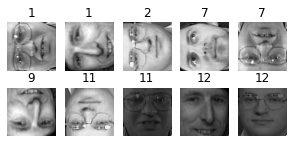

In [214]:
plot_faces(X_bad_faces, y_gen_faces)

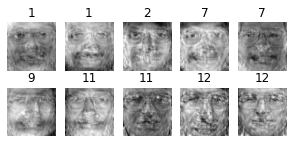

In [215]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_gen_faces)